# MnemoDyn HF Inference Tutorial

Load a foundation checkpoint from Hugging Face, run inference on one demo parcellated dtseries file, and visualize input vs output.

## Environment Setup

Choose the setup that matches your environment.

**Local machine (recommended):**
```bash
git clone https://github.com/<your-org-or-user>/MnemoDyn_Draft.git
cd MnemoDyn_Draft
uv venv .venv
source .venv/bin/activate
uv pip install -r highdim_req.txt
uv pip install huggingface_hub
```

**Google Colab (no venv):**
```bash
git clone https://github.com/<your-org-or-user>/MnemoDyn_Draft.git
cd MnemoDyn_Draft
pip install -q uv
uv pip install --system -r highdim_req.txt
uv pip install --system huggingface_hub
```


In [1]:
# Optional: run setup commands from notebook (Linux/macOS shell).
# Remove `echo` if you want to execute for real in this notebook environment.
!git clone https://github.com/vietluong2110/MnemoDyn_Draft.git
%cd MnemoDyn_Draft
!pip install -q uv
!uv pip install --system -r highdim_req.txt
!uv pip install --system huggingface_hub



Cloning into 'MnemoDyn_Draft'...
remote: Enumerating objects: 295, done.
remote: Counting objects: 100% (295/295), done.
remote: Compressing objects: 100% (165/165), done.
remote: Total 295 (delta 178), reused 245 (delta 128), pack-reused 0 (from 0)
Receiving objects: 100% (295/295), 14.55 MiB | 18.17 MiB/s, done.
Resolving deltas: 100% (178/178), done.
/content/MnemoDyn_Draft
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 52.1 MB/s eta 0:00:00
Using Python 3.12.12 environment at: /usr
Resolved 113 packages in 786ms
Prepared 98 packages in 45.96s
Uninstalled 78 packages in 1.46s
Installed 98 packages in 788ms
 - absl-py==1.4.0
 + absl-py==2.1.0
 - aiohappyeyeballs==2.6.1
 + aiohappyeyeballs==2.5.0
 - aiohttp==3.13.3
 + aiohttp==3.11.13
 - aiosignal==1.4.0
 + aiosignal==1.3.2
 + asttokens==3.0.0
 - attrs==25.4.0
 + attrs==25.1.0
 - certifi==2026.1.4
 + certifi==2025.1.31
 - charset-normalizer==3.4.4
 + charset-normalizer==3.4.1
 + colorama==0.4.6
 + comm==0.2.2
 - contourpy==1

In [2]:
!uv pip install --system "numpy==2.0.0"

Using Python 3.12.12 environment at: /usr
Resolved 1 package in 25ms
Prepared 1 package in 496ms
Uninstalled 1 package in 18ms
Installed 1 package in 27ms
 - numpy==2.2.3
 + numpy==2.0.0


In [3]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import torch
import torchcde
from huggingface_hub import hf_hub_download

# Ensure repository root is on sys.path when running notebook directly.
repo_root = Path.cwd()
while repo_root != repo_root.parent and not (repo_root / 'coe').exists():
    repo_root = repo_root.parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

from coe.light.model.main import LitORionModelOptimized


/content/MnemoDyn_Draft/coe/light/model/orion.py:300: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast()


In [4]:
# ---- Configure HF model + demo data path ----
HF_MODEL_REPO_ID = 'vhluong/MnemoDyn'
HF_CKPT_PATH_IN_REPO = 'Orion_450_ukbiobank/model.ckpt'  # e.g. Orion_333/model.ckpt
HF_REVISION = 'main'

# Demo parcellated dtseries file (local).
# Demo dtseries from Hugging Face Dataset repo.
HF_DATASET_REPO_ID = 'vhluong/MnemoDyn_demo_dataset'
HF_DEMO_FILE_PATH_IN_DATASET = 'demo_data/ds005747_parcellated_all.tar.gz'
HF_DATASET_REVISION = 'main'

# Interpolation must match model expectation.
INTERPOL = 'spline'  # or 'linear'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)


Device: cuda


In [5]:
download_dtseries_path = hf_hub_download(
    repo_id=HF_DATASET_REPO_ID,
    filename=HF_DEMO_FILE_PATH_IN_DATASET,
    repo_type='dataset',
    revision=HF_DATASET_REVISION,
)
print('Downloaded demo dtseries:', download_dtseries_path)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


demo_data/ds005747_parcellated_all.tar.g(…):   0%|          | 0.00/215M [00:00<?, ?B/s]

Downloaded demo dtseries: /root/.cache/huggingface/hub/datasets--vhluong--MnemoDyn_demo_dataset/snapshots/345e86c692dbe3c7c71e856f89bb65914768ec22/demo_data/ds005747_parcellated_all.tar.gz


In [6]:
!mkdir demo_data

In [9]:
print(download_dtseries_path)
!ls -lh "{download_dtseries_path}"
!tar -xzvf "{download_dtseries_path}" -C ./demo_data

/root/.cache/huggingface/hub/datasets--vhluong--MnemoDyn_demo_dataset/snapshots/345e86c692dbe3c7c71e856f89bb65914768ec22/demo_data/ds005747_parcellated_all.tar.gz
lrwxrwxrwx 1 root root 79 Feb 26 21:57 /root/.cache/huggingface/hub/datasets--vhluong--MnemoDyn_demo_dataset/snapshots/345e86c692dbe3c7c71e856f89bb65914768ec22/demo_data/ds005747_parcellated_all.tar.gz -> ../../../blobs/0a359fb00063ac0208c0f838057c69e2f1e74fb1d19b3f8f79bbfe0194e8c9b4
sub-011/sub-011_task-rest_space-MNI305_preproc.dtseries_Schaefer2018_400Parcels_7Networks_order_Tian_Subcortex_S3.dlabel_parcellated.dtseries.nii
sub-012/sub-012_task-rest_space-MNI305_preproc.dtseries_Schaefer2018_400Parcels_7Networks_order_Tian_Subcortex_S3.dlabel_parcellated.dtseries.nii
sub-013/sub-013_task-rest_space-MNI305_preproc.dtseries_Schaefer2018_400Parcels_7Networks_order_Tian_Subcortex_S3.dlabel_parcellated.dtseries.nii
sub-018/sub-018_task-rest_space-MNI305_preproc.dtseries_Schaefer2018_400Parcels_7Networks_order_Tian_Subcortex_S3.

In [10]:
def load_dtseries(file_path: Path, target_length: int, num_parcels: int) -> torch.Tensor:
    arr = nib.load(str(file_path)).get_fdata().astype(np.float32)  # [T, D]
    if arr.ndim != 2:
        raise ValueError(f'Expected 2D dtseries array, got {arr.shape}')
    if arr.shape[1] != num_parcels:
        raise ValueError(f'Expected D={num_parcels}, got D={arr.shape[1]}')

    reps = int(np.ceil(target_length / arr.shape[0]))
    arr = np.tile(arr, (reps, 1))[:target_length]
    return torch.from_numpy(arr).unsqueeze(0)  # [1, T, D]


ckpt_path = hf_hub_download(
    repo_id=HF_MODEL_REPO_ID,
    filename=HF_CKPT_PATH_IN_REPO,
    revision=HF_REVISION,
)
print('Downloaded checkpoint:', ckpt_path)

demo_dtseries_path = Path("./demo_data/sub-011/sub-011_task-rest_space-MNI305_preproc.dtseries_Schaefer2018_400Parcels_7Networks_order_Tian_Subcortex_S3.dlabel_parcellated.dtseries.nii")

lit = LitORionModelOptimized.load_from_checkpoint(ckpt_path, map_location=device)
lit.eval()
foundation = lit.model.to(device)
for p in foundation.parameters():
    p.requires_grad = False

seq_length = 490
num_parcels = int(lit.hparams.D)
duration = float(lit.hparams.duration)

if not demo_dtseries_path.exists():
    raise FileNotFoundError(f'Demo dtseries not found: {demo_dtseries_path}')

x = load_dtseries(demo_dtseries_path, target_length=seq_length, num_parcels=num_parcels).to(device)

if INTERPOL == 'linear':
    coeffs = torchcde.linear_interpolation_coeffs(x)
elif INTERPOL == 'spline':
    coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(x)
else:
    raise ValueError("INTERPOL must be 'linear' or 'spline'")

time_step = torch.from_numpy(np.arange(0, duration, duration / seq_length)).float().to(device)


with torch.no_grad():

    U = foundation(x, coeffs, time_step.unsqueeze(0))

print('Input shape :', tuple(x.shape))
print('Output shape:', tuple(U.shape))


model.ckpt:   0%|          | 0.00/1.78G [00:00<?, ?B/s]

Downloaded checkpoint: /root/.cache/huggingface/hub/models--vhluong--MnemoDyn/snapshots/4c7203b4bcceb0c9e8c1cf78009d59690efed35d/Orion_450_ukbiobank/model.ckpt
Output sizes: [16, 31, 62, 123, 245]
Output sizes: [16, 31, 62, 123, 245]
Output sizes: [16, 31, 62, 123, 245]
Output sizes: [16, 31, 62, 123, 245]
Input shape : (1, 490, 450)
Output shape: (1, 490, 450)


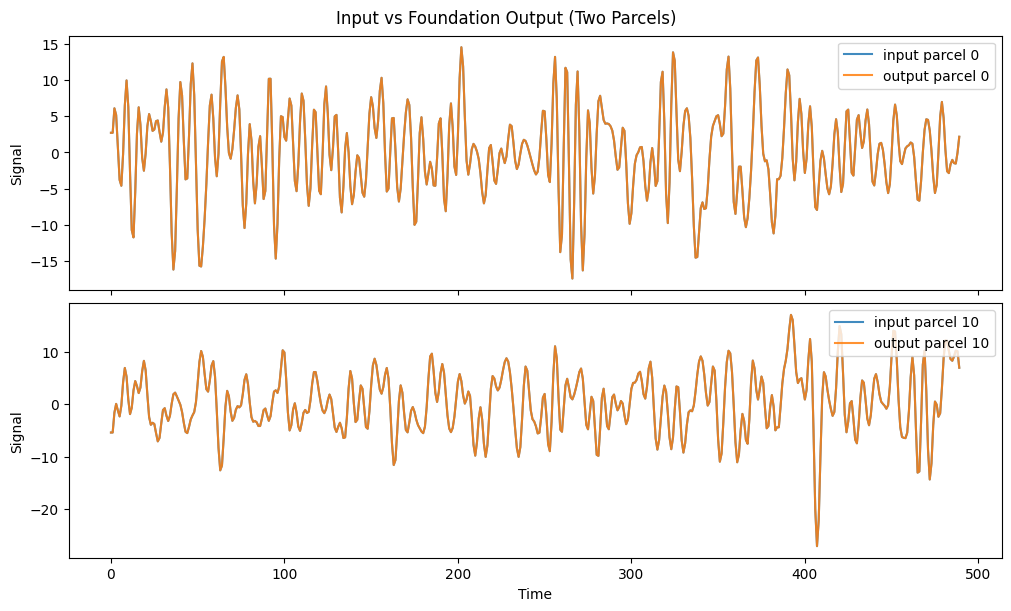

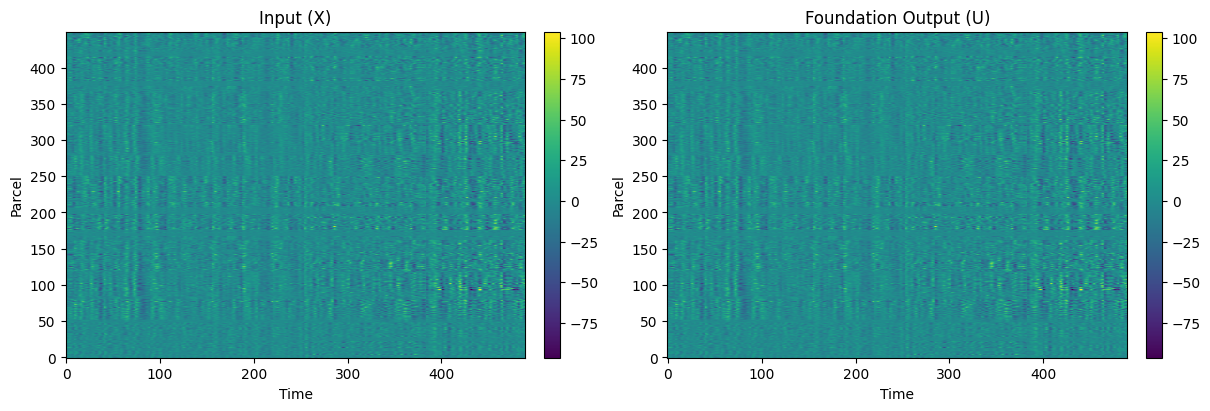

MAE: 0.000139
MSE: 0.000000


In [11]:
# Visualize two parcel time series + heatmaps (input vs foundation output)
parcel_idxs = [0, 10]  # change to any two parcel indices you want
x_cpu = x[0].detach().cpu().numpy()   # [T, D]
u_cpu = U[0].detach().cpu().numpy()   # [T, D]

# 1) Two time-series comparisons
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True, constrained_layout=True)
for i, pidx in enumerate(parcel_idxs):
    axes[i].plot(x_cpu[:, pidx], label=f"input parcel {pidx}", alpha=0.85)
    axes[i].plot(u_cpu[:, pidx], label=f"output parcel {pidx}", alpha=0.85)
    axes[i].set_ylabel("Signal")
    axes[i].legend(loc="upper right")
axes[-1].set_xlabel("Time")
fig.suptitle("Input vs Foundation Output (Two Parcels)")
plt.show()

# 2) Heatmap comparisons (time x parcel)
fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
im0 = axes[0].imshow(x_cpu.T, aspect="auto", origin="lower", interpolation="nearest", cmap="viridis")
axes[0].set_title("Input (X)")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Parcel")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(u_cpu.T, aspect="auto", origin="lower", interpolation="nearest", cmap="viridis")
axes[1].set_title("Foundation Output (U)")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Parcel")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

plt.show()

# Optional: error summary
mae = torch.mean(torch.abs(U - x)).item()
mse = torch.mean((U - x) ** 2).item()
print(f"MAE: {mae:.6f}")
print(f"MSE: {mse:.6f}")

